In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
spot_price = 2878.99
today = pd.to_datetime('20190409', format='%Y%m%d', errors='coerce')
nb_trading_days = 365

In [3]:
raw_spx = pd.read_csv("./data/SPX_20190409.csv", skiprows=2)
raw_spx = raw_spx[raw_spx['Calls'].apply(lambda s: s.startswith('SPXW'))]
raw_spx['Expiration Date'] =  pd.to_datetime(raw_spx['Expiration Date'], format='%m/%d/%Y')
raw_spx['Time to Maturity (years)'] = raw_spx['Expiration Date'].apply(lambda exp_date: (exp_date-today).days/nb_trading_days)
raw_spx['Log Moneyness'] = np.log(raw_spx['Strike']/spot_price)

In [4]:
raw_spx.head()

,Expiration Date,Calls,Last Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,...,Net.1,Bid.1,Ask.1,Vol.1,IV.1,Delta.1,Gamma.1,Open Int.1,Time to Maturity (years),Log Moneyness
0,2019-04-10,SPXW190410C01700000,0.0,0.0,1173.1,1184.5,0,0.0,0.9996,0.0,...,0.0,0.0,0.05,0,2.6312,-0.0002,0.0,35,0.00274,-0.526811
1,2019-04-10,SPXW190410C01800000,0.0,0.0,1072.5,1083.9,0,0.0,0.9996,0.0,...,0.0,0.0,0.05,0,2.3577,-0.0002,0.0,42,0.00274,-0.469653
2,2019-04-10,SPXW190410C01850000,0.0,0.0,1022.6,1033.9,0,0.0,0.9992,0.0,...,0.0,0.0,0.05,0,2.2318,-0.0003,0.0,66,0.00274,-0.442254
3,2019-04-10,SPXW190410C01900000,0.0,0.0,972.8,984.2,0,0.0,0.9996,0.0,...,0.0,0.0,0.05,0,2.0944,-0.0003,0.0,22,0.00274,-0.415586
4,2019-04-10,SPXW190410C01950000,0.0,0.0,922.4,933.7,0,0.0,0.9967,0.0,...,0.0,0.0,0.05,0,1.9698,-0.0003,0.0,225,0.00274,-0.389610


In [5]:
call_data = raw_spx.loc[:, ['Bid', 'Ask', 'IV', 'Open Int', 'Time to Maturity (years)', 'Log Moneyness', 'Strike']]
put_data = raw_spx.loc[:, ['Bid.1', 'Ask.1', 'IV.1', 'Open Int.1', 'Time to Maturity (years)', 'Log Moneyness', 'Strike']]
put_data.columns = call_data.columns

call_data['Mid'] = (call_data['Bid'] + call_data['Ask']) / 2
put_data['Mid'] = (put_data['Bid'] + put_data['Ask']) / 2

In [6]:
call_data.head()

,Bid,Ask,IV,Open Int,Time to Maturity (years),Log Moneyness,Strike,Mid
0,1173.1,1184.5,0.0,0,0.00274,-0.526811,1700.0,1178.80
1,1072.5,1083.9,0.0,0,0.00274,-0.469653,1800.0,1078.20
2,1022.6,1033.9,0.0,0,0.00274,-0.442254,1850.0,1028.25
3,972.8,984.2,0.0,0,0.00274,-0.415586,1900.0,978.50
4,922.4,933.7,0.0,0,0.00274,-0.389610,1950.0,928.05


In [7]:
put_data.head()

,Bid,Ask,IV,Open Int,Time to Maturity (years),Log Moneyness,Strike,Mid
0,0.0,0.05,2.6312,35,0.00274,-0.526811,1700.0,0.025
1,0.0,0.05,2.3577,42,0.00274,-0.469653,1800.0,0.025
2,0.0,0.05,2.2318,66,0.00274,-0.442254,1850.0,0.025
3,0.0,0.05,2.0944,22,0.00274,-0.415586,1900.0,0.025
4,0.0,0.05,1.9698,225,0.00274,-0.389610,1950.0,0.025


In [8]:
call_data.to_csv("./data/processed_spx_calls_all_liquids.csv")
put_data.to_csv("./data/processed_spx_puts_all_liquids.csv")

## Liquidity filtration

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

In [10]:
call_data = call_data[call_data['Open Int']!=0]
put_data = put_data[put_data['Open Int']!=0]

call_data['Inv Spread'] = 1. / (call_data['Ask'] - call_data['Bid'])
put_data['Inv Spread'] = 1. / (put_data['Ask'] - put_data['Bid'])

In [11]:
def plot_heatmap(data, values='Inv Spread'):
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot(index='Time to Maturity (years)', columns='Log Moneyness', values=values)
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap=plt.cm.Spectral, cbar=True, xticklabels=15, yticklabels=2)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

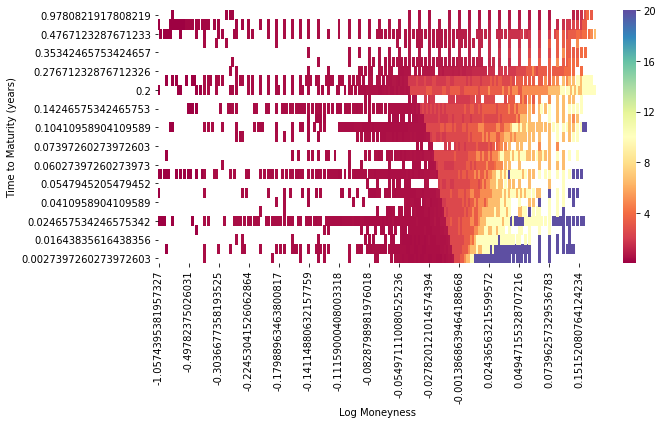

In [12]:
plot_heatmap(call_data, 'Inv Spread')

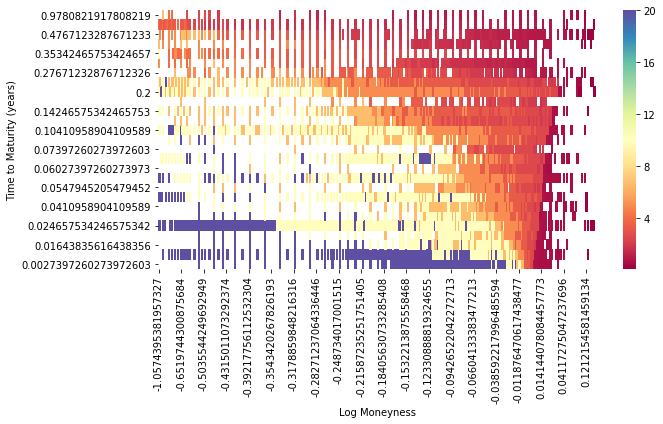

In [13]:
plot_heatmap(put_data, 'Inv Spread')

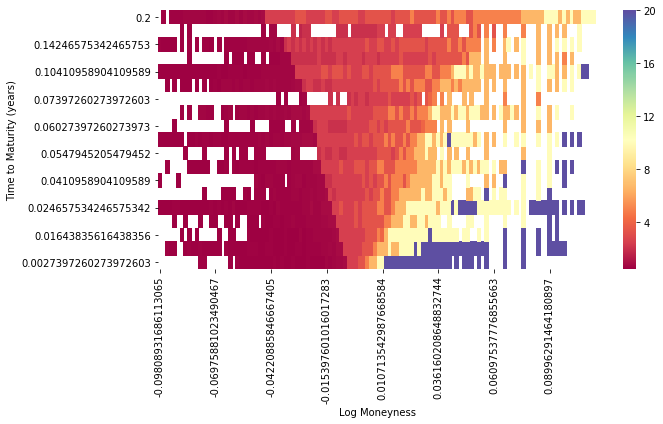

In [14]:
liquid_criterion = (-0.1 <= call_data['Log Moneyness']) & (call_data['Log Moneyness'] <= 0.28) & (1/365 <= call_data['Time to Maturity (years)']) & (call_data['Time to Maturity (years)'] <= 0.2)
call_data_liquid = call_data[liquid_criterion].copy()
plot_heatmap(call_data_liquid, 'Inv Spread')

In [15]:
call_data_liquid.sort_values('Inv Spread', inplace=True, ascending=False)
call_data_liquid.to_csv("./data/spx_liquid_calls.csv")
call_data_liquid.head()

,Bid,Ask,IV,Open Int,Time to Maturity (years),Log Moneyness,Strike,Mid,Inv Spread
112,0.1,0.15,0.1159,2390,0.002740,0.014144,2920.0,0.125,20.0
1274,0.0,0.05,0.1710,1,0.024658,0.083593,3130.0,0.025,20.0
132,0.0,0.05,0.2826,10,0.002740,0.047817,3020.0,0.025,20.0
338,0.0,0.05,0.1242,9309,0.008219,0.032805,2975.0,0.025,20.0
525,0.0,0.05,0.2223,3,0.016438,0.089963,3150.0,0.025,20.0


In [16]:
mat_vals = call_data_liquid['Time to Maturity (years)'].unique()

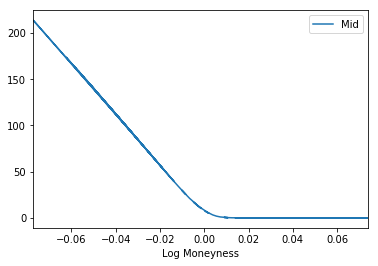

In [17]:
call_data_liquid[call_data_liquid['Time to Maturity (years)'] == mat_vals[0]].plot(x='Log Moneyness', y='Mid')

## (K, T) distribution estimation

In [18]:
data = pd.read_csv("./data/processed_spx_calls_all_liquids.csv", index_col=0)
data.head()

,Bid,Ask,IV,Open Int,Time to Maturity (years),Log Moneyness,Strike,Mid
0,1173.1,1184.5,0.0,0,0.00274,-0.526811,1700.0,1178.80
1,1072.5,1083.9,0.0,0,0.00274,-0.469653,1800.0,1078.20
2,1022.6,1033.9,0.0,0,0.00274,-0.442254,1850.0,1028.25
3,972.8,984.2,0.0,0,0.00274,-0.415586,1900.0,978.50
4,922.4,933.7,0.0,0,0.00274,-0.389610,1950.0,928.05


In [19]:
total_interest = data['Open Int'].sum()
interests = pd.DataFrame(index=np.arange(total_interest), columns=['Time to Maturity (years)', 'Log Moneyness'], dtype=float)

counter = 0
for idx in data.index:
    num_int = data.loc[idx, 'Open Int']
    end_counter = counter + num_int
    interests.iloc[counter:end_counter, :] = data.loc[idx, ['Time to Maturity (years)', 'Log Moneyness']].values
    counter = end_counter

In [20]:
interests.head()

,Time to Maturity (years),Log Moneyness
0,0.00274,-0.364292
1,0.00274,-0.186146
2,0.00274,-0.151199
3,0.00274,-0.151199
4,0.00274,-0.131198


#### seaborn visualize KDE

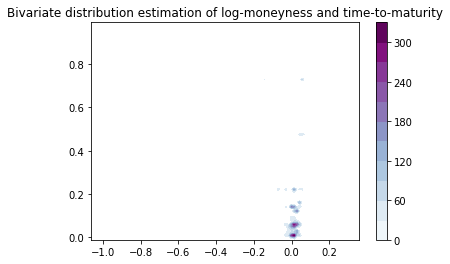

In [162]:
fig, ax = plt.subplots()
ax.set_title("Bivariate distribution estimation of log-moneyness and time-to-maturity")
x = interests['Log Moneyness'].values
y = interests['Time to Maturity (years)'].values
ax = sns.kdeplot(x, y, cbar=True, shade=True, shade_lowest=False, cmap='BuPu')

#### Scikit-learn KDE

In [27]:
import sys
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import statsmodels.nonparametric.api as smnp

In [24]:
K_T = data[['Time to Maturity (years)', 'Log Moneyness']].values
K_T[:, 1] = np.exp(K_T[:, 1])

In [29]:
# grid search cv for best bandwidth
params = {'bandwidth': np.logspace(-3, -1, 5)}
grid = GridSearchCV(KernelDensity(), params, verbose=sys.maxsize, n_jobs=-1, cv=5)
grid.fit(K_T)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(4842, 2), dtype=float64).
Pickling array (shape=(3873,), dtype=int32).
Pickling array (shape=(969,), dtype=int32).
Pickling array (shape=(4842, 2), dtype=float64).
Pickling array (shape=(3873,), dtype=int32).
Pickling array (shape=(969,), dtype=int32).
Pickling array (shape=(4842, 2), dtype=float64).
Pickling array (shape=(3874,), dtype=int32).
Pickling array (shape=(968,), dtype=int32).
Pickling array (shape=(4842, 2), dtype=float64).
Pickling array (shape=(3874,), dtype=int32).
Pickling array (shape=(968,), dtype=int32).
Pickling array (shape=(4842, 2), dtype=float64).
Pickling array (shape=(3874,), dtype=int32).
Pickling array (shape=(968,), dtype=int32).
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
Pickling array (shape=(4842, 2), dtype=float64).
Pickling array (shape=(3873,), dtype=int32).
Pickling array (sh

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bandwidth': array([0.001  , 0.00316, 0.01   , 0.03162, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=9223372036854775807)

In [31]:
kde = grid.best_estimator_

In [32]:
kde.fit(K_T)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [49]:
from IPython.display import display, clear_output

In [50]:
n_samples = int(1e6)

generated_K_T = pd.DataFrame(index=np.arange(n_samples), columns=['Moneyness', 'Time to Maturity (years)'], dtype=float)

counter = 0

while counter < n_samples:
    clear_output()
    display("Generated {}% valid samples".format(counter/n_samples * 100))
    still_need = n_samples - counter
    samples = kde.sample(still_need)
    is_valid = (samples[:, 0] > 0.75) & (samples[:, 0] < 1.2) & (samples[:, 1] > 0) & (samples[:, 1] < 0.25)
    valid_samples = samples[is_valid]
    n_valid = len(valid_samples)
    new_counter = counter + n_valid
    generated_K_T.iloc[counter:new_counter, :] = valid_samples
    counter = new_counter

'Generated 999999 valid samples'

In [55]:
generated_K_T.shape

(1000000, 2)

In [54]:
generated_K_T.head()

,Moneyness,Time to Maturity (years)
0,0.820165,0.219184
1,0.926490,0.212487
2,0.834318,0.190719
3,1.053977,0.226441
4,0.802749,0.208923


In [56]:
generated_K_T.to_csv("./data/strike_maturity.csv")